<a href="https://colab.research.google.com/github/tnusser/ImageRetrieval/blob/master/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports


In [121]:
import tensorflow as tf
import numpy as np
import sklearn
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Flatten, Conv2DTranspose, Reshape
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
import keras.backend as K 
import matplotlib.pyplot as plt
import seaborn as sns
import random

## 3.1 Dataset Preparation

In [2]:
 (raw_x_train, raw_y_train), (raw_x_test, raw_y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [3]:
x_train = (raw_x_train/255).astype("float32")
x_test = (raw_x_test/255).astype("float32")

## 3.2 Building the Autoencoder

In [38]:
x_val = x_train[:3000]
x_train = x_train[3000:15000]

In [188]:
i = Input(shape=(32, 32, 3), name="input_layer")
e1 = Conv2D(32, (3, 3), activation='relu', padding='same', name="conv_1")(i)
e6 = Flatten()(e1)
e7 = Dense(10, activation='relu', name="latent_space")(e6)

conv_shape = K.int_shape(e1)
d_i = Input(shape=(10,))
d1 = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu',)(d_i)
d2 = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(d1)
d6 = Conv2DTranspose(filters=3, kernel_size=3, activation="sigmoid", padding="same")(d2)

encoder = Model(i, e7, name='encoder')
encoder.summary()
decoder = Model(d_i, d6, name='decoder')
decoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 32, 32, 3)         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
flatten_13 (Flatten)         (None, 32768)             0         
_________________________________________________________________
latent_space (Dense)         (None, 10)                327690    
Total params: 328,586
Trainable params: 328,586
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 10)                0         
____________________________________

In [187]:
i = Input(shape=(32, 32, 3))
e1 = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
e2 = MaxPooling2D(pool_size=(2, 2))(e1)
e3 = Conv2D(64, (3, 3), activation="relu", padding='same')(e2)
e4 = MaxPooling2D(pool_size=(3, 3))(e3)
e5 = Conv2D(128, (3,3), activation="relu", padding='same')(e4)
e6 = Flatten()(e5)
e7 = Dense(10, activation='relu')(e6)

encoder = Model(i, e7, name='encoder')
encoder.summary()

conv_shape = K.int_shape(e1)
d_i = Input(shape=(10,))
d1 = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu',)(d_i)
d2 = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(d1)
d4 = Conv2DTranspose(filters=32, kernel_size=3, activation="relu", padding="same")(d2)
d5 = Conv2DTranspose(filters=16, kernel_size=3, activation="relu", padding="same")(d4)
d6 = Conv2DTranspose(filters=3, kernel_size=3, activation="sigmoid", padding="same")(d5)

decoder = Model(d_i, d6, name='decoder')
decoder.summary()


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 32, 32, 3)         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 5, 5, 128)         73856     
_________________________________________________________________
flatten_12 (Flatten)         (None, 3200)              0   

In [189]:
autoencoder_outputs = decoder(encoder(i))
autoencoder = Model(i, autoencoder_outputs, name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 32, 32, 3)         0         
_________________________________________________________________
encoder (Model)              (None, 10)                328586    
_________________________________________________________________
decoder (Model)              (None, 32, 32, 3)         361315    
Total params: 689,901
Trainable params: 689,901
Non-trainable params: 0
_________________________________________________________________


In [190]:
checkpoint = ModelCheckpoint('{val_accuracy:.4f}.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history = autoencoder.fit(x_train, x_train, validation_data=(x_val, x_val), epochs=1, batch_size=512, callbacks=[checkpoint])

Train on 12000 samples, validate on 3000 samples
Epoch 1/1
12000/12000 [==============================] - 16s 1ms/step - loss: 0.0589 - accuracy: 0.4357 - val_loss: 0.0498 - val_accuracy: 0.4374

Epoch 00001: val_accuracy improved from -inf to 0.43739, saving model to 0.4374.hdf5


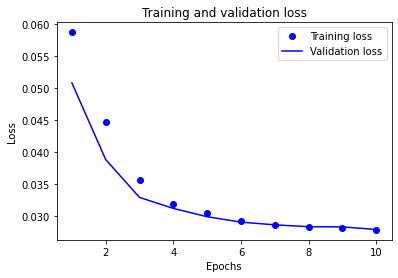

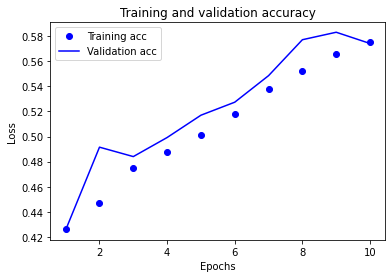

In [40]:
# Loss plot
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy plot
plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [170]:
autoencoder.load_weights("0.5830.hdf5")
preds = autoencoder.predict(x_test)

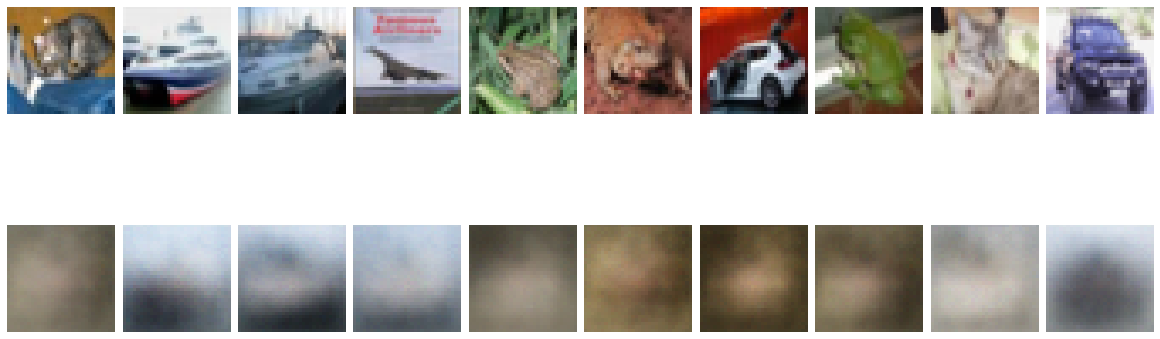

In [171]:
f, axarr = plt.subplots(2, 10, constrained_layout=True)
f.set_size_inches(16, 6)
for i in range(10):
    original = x_test[i]
    axarr[0, i].imshow(original)
    axarr[0, i].axis('off')
    prediction = preds[i]
    axarr[1, i].imshow(prediction)
    axarr[1, i].axis('off')
plt.show()


In [215]:
samples = random.sample(list(x_test), 50)
#encoder_output = K.function([autoencoder.layers[0].input, K.learning_phase()], [autoencoder.get_layer("encoder").get_layer("latent_space").output])
#layer_output=autoencoder.get_layer("encoder").get_layer("latent_space")
intermediate_layer_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("encoder").get_layer("latent_space").output)



#out = []
#for sample in samples:
#  out.append(intermediate_layer_model(sample))
intermediate_output = intermediate_layer_model.predict(np.asarray(samples))

In [217]:
print(intermediate_output)

[[0.00000000e+00 1.47280092e+01 6.72915220e+00 0.00000000e+00
  4.80477452e-01 0.00000000e+00 1.32538052e+01 0.00000000e+00
  5.35416651e+00 2.47116871e+01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  4.59137976e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.45796089e+01]
 [0.00000000e+00 1.12216434e+01 5.16058350e+00 0.00000000e+00
  4.39249694e-01 0.00000000e+00 1.12877369e+01 0.00000000e+00
  5.17965841e+00 1.75241642e+01]
 [0.00000000e+00 6.26444101e+00 1.73986232e+00 0.00000000e+00
  3.79042655e-01 0.00000000e+00 4.53150606e+00 0.00000000e+00
  1.26395369e+00 1.33133669e+01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  3.51154506e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.92639408e+01]
 [6.20346069e+00 9.55675983e+00 7.16565180e+00 0.00000000e+00
  2.09548622e-01 3.99352491e-01 1.07148771e+01 3.90417814e+00
  9.01664448e+00 1.21342707e+01]
 [0.00000000e+00 7.24170113e+00 5.41613770e+00 0.00000000e

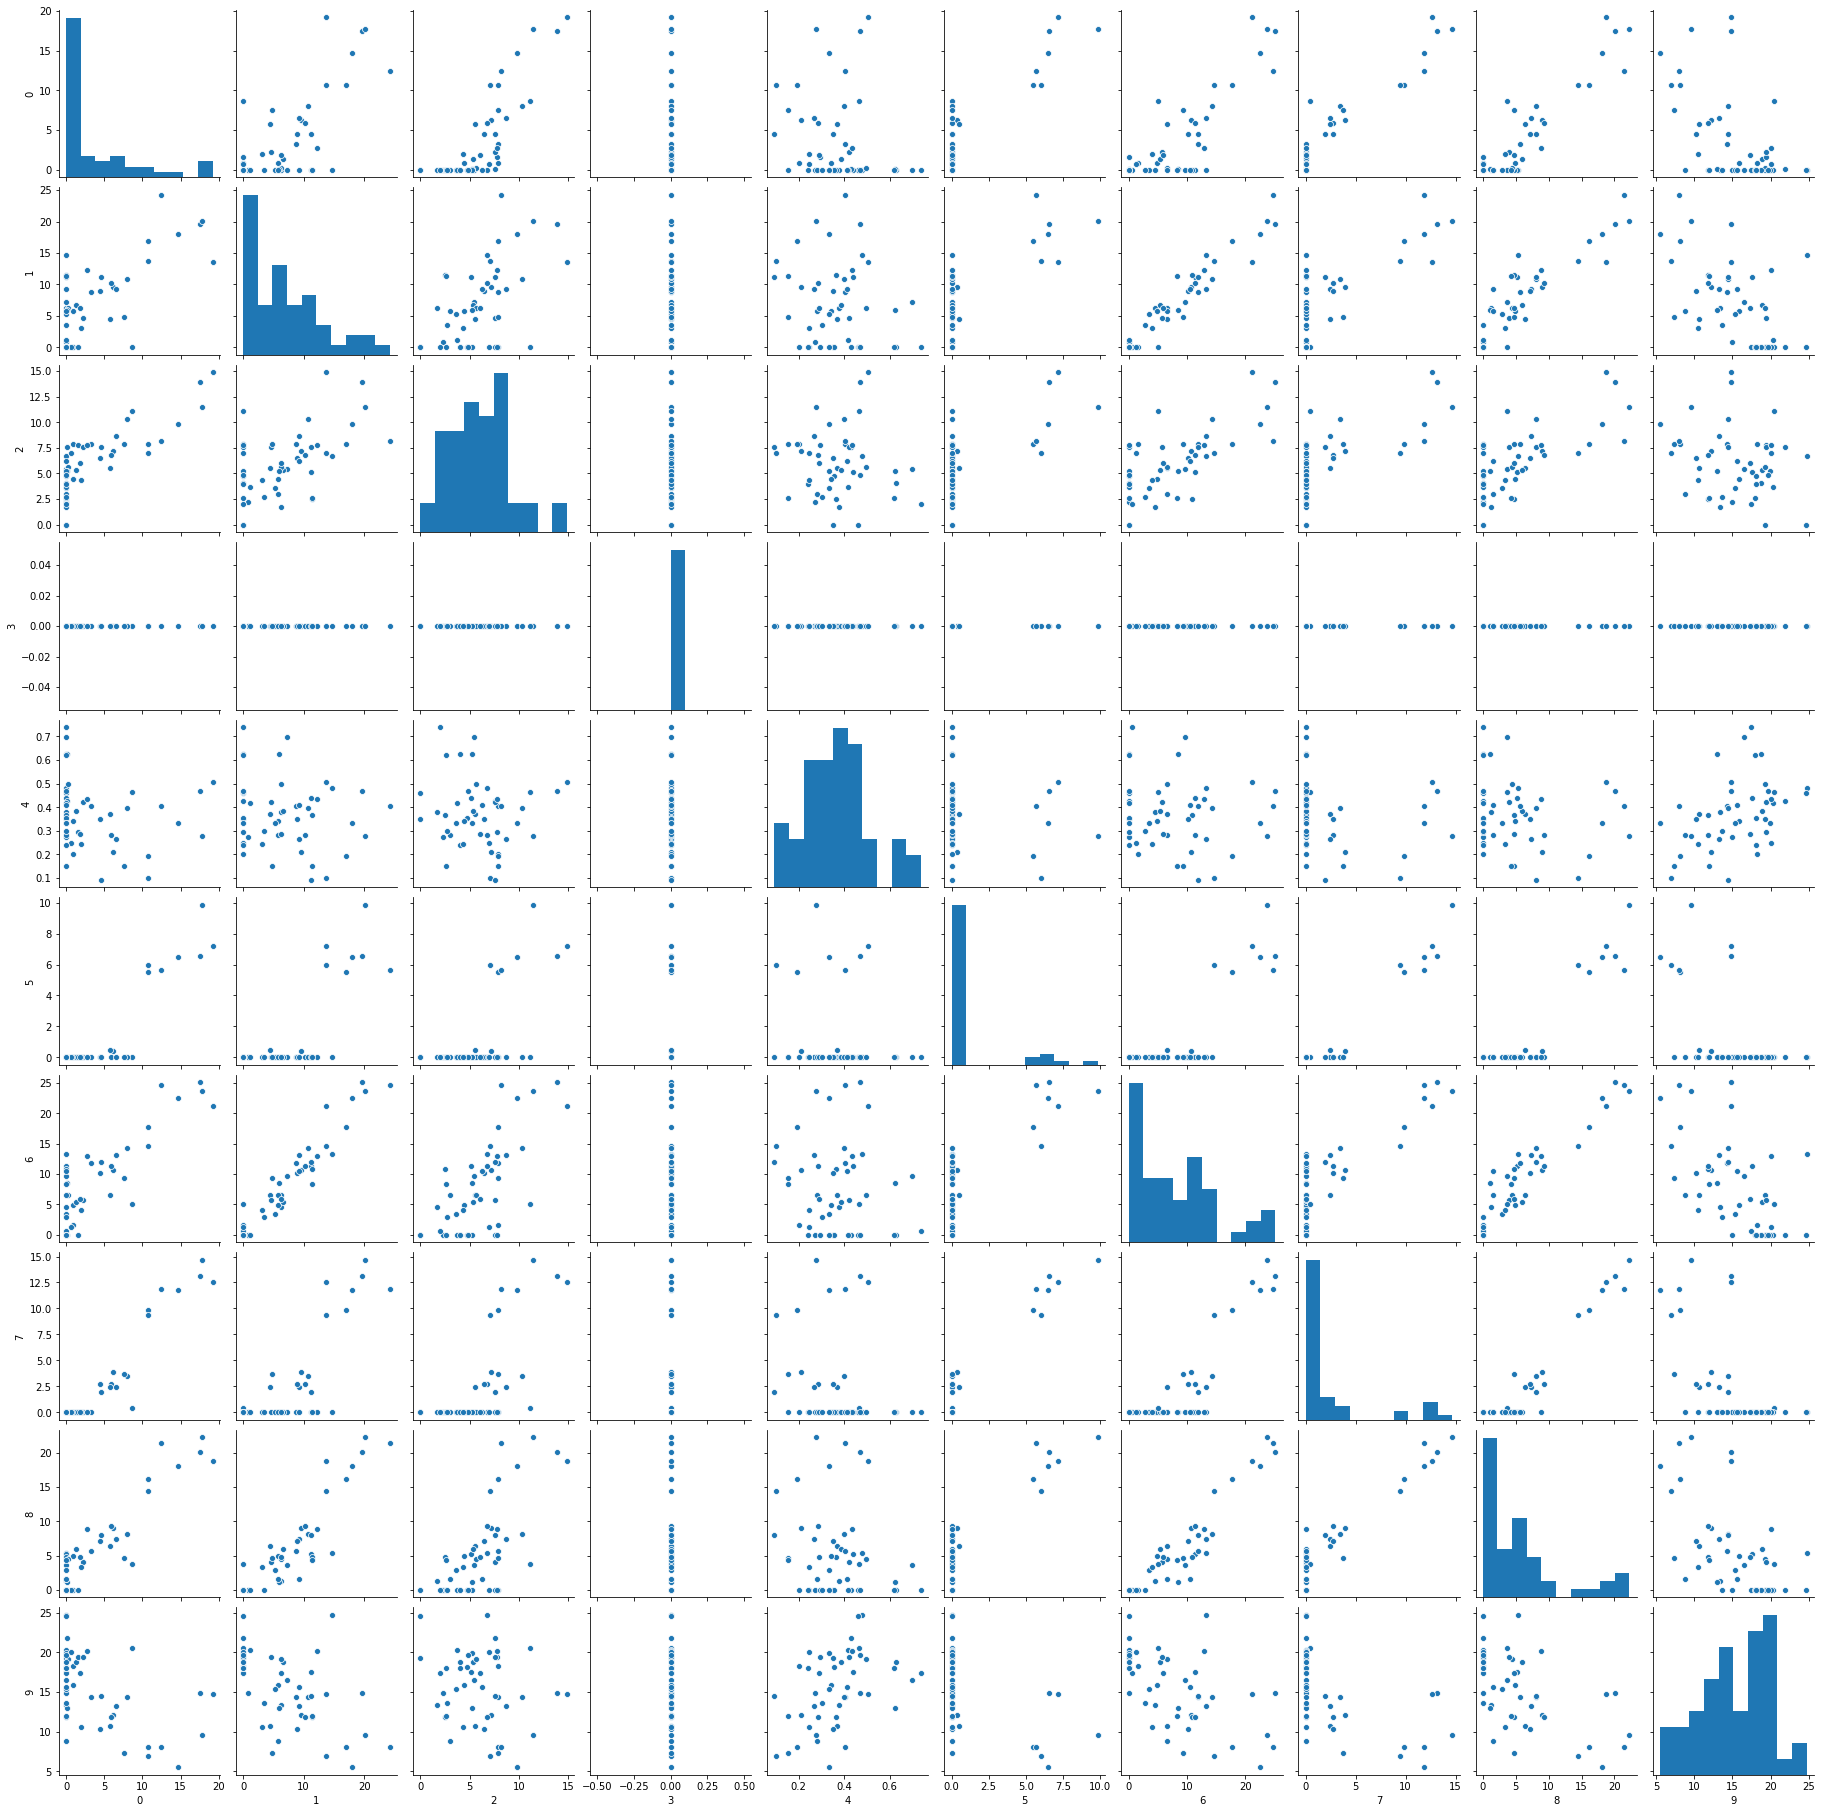

In [221]:
import pandas as pd

df = pd.DataFrame(intermediate_output)
sns.pairplot(df)